### TODO
- Manage NA values
- Manage useless features
    - `year` : merge with name
    - `link`, `logo` : delete
- Looking for strange values
    - score_i > score_j && rank_i > rank_j
- Using pandas categories
    - `country`, `city`, `region`
    - `type`, `size`, `research_ouptut`
- Looking for correlation between features
- Calculate rank for values with score but no rank (Temporarily dropped rows with no rank)


### Rapport du prof
- Tester différentes métriques
- Modèles à utiliser :
    - Linear model 
    - XGBoost ++
    - Decision tree
- Visualiser les données (matrice de corrélation)


### Notebook settings and imports

In [50]:
import numpy as np

import pandas as pd
from pandas.api.types import is_object_dtype, is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics


%matplotlib inline

In [51]:
data_init = pd.read_csv("qs-world-university-rankings-2017-to-2022-V2.csv")
N_init, D_init = data_init.shape
data_init.head()

,university,year,rank_display,score,link,country,city,region,logo,type,research_output,student_faculty_ratio,international_students,size,faculty_count
0,Massachusetts Institute of Technology (MIT),2017,1,100.0,https://www.topuniversities.com/universities/m...,United States,Cambridge,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,4.0,"3,730",M,"3,065"
1,Stanford University,2017,2,98.7,https://www.topuniversities.com/universities/s...,United States,Stanford,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,3.0,"3,879",L,"4,725"
2,Harvard University,2017,3,98.3,https://www.topuniversities.com/universities/h...,United States,Cambridge,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,5.0,"5,877",L,"4,646"
3,University of Cambridge,2017,4,97.2,https://www.topuniversities.com/universities/u...,United Kingdom,Cambridge,Europe,https://www.topuniversities.com/sites/default/...,Public,Very high,4.0,"7,925",L,"5,800"
4,California Institute of Technology (Caltech),2017,5,96.9,https://www.topuniversities.com/universities/c...,United States,Pasadena,North America,https://www.topuniversities.com/sites/default/...,Private,Very High,2.0,692,S,968


In [52]:
data_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6482 entries, 0 to 6481
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   university              6482 non-null   object 
 1   year                    6482 non-null   int64  
 2   rank_display            6414 non-null   object 
 3   score                   2820 non-null   float64
 4   link                    6482 non-null   object 
 5   country                 6482 non-null   object 
 6   city                    6304 non-null   object 
 7   region                  6482 non-null   object 
 8   logo                    6482 non-null   object 
 9   type                    6470 non-null   object 
 10  research_output         6480 non-null   object 
 11  student_faculty_ratio   6407 non-null   float64
 12  international_students  6318 non-null   object 
 13  size                    6480 non-null   object 
 14  faculty_count           6404 non-null   

In [53]:
data_init.isna().sum()

university                   0
year                         0
rank_display                68
score                     3662
link                         0
country                      0
city                       178
region                       0
logo                         0
type                        12
research_output              2
student_faculty_ratio       75
international_students     164
size                         2
faculty_count               78
dtype: int64

### Clean-up : useless features

In [54]:
# drop useless columns
useless_columns = [
    "link",
    "logo"
]
data = data_init.drop(columns=useless_columns, axis=1)

# merge year with university's name
university_with_year = data["university"] + data["year"].map(" ({})".format)
data.insert(0, "university_with_year", university_with_year)
    # data = data.drop(columns=["university", "year"], axis=1)

In [55]:
# On change les N-M en N

rank_display_raw = data["rank_display"].map(lambda rank: str(rank).split("-")[0], na_action='ignore')
rank_display_raw = rank_display_raw.fillna(0)  # pour pouvoir convertir en entier
rank_display_raw = rank_display_raw.astype('int64')

data.insert(4, "rank_display_raw", rank_display_raw)
data["rank_display_raw"] = data['rank_display_raw'].replace(0, np.nan)

In [56]:
#Creating new feature for classification
data["class"] = [i//100 for i in data["rank_display_raw"]]

### Converting objects to categorical

In [57]:
#international_students and faculty_count are integers written as strings
for col in ["international_students", "faculty_count"]:
    if is_object_dtype(data[col]):
        data[col] = data[col].str.replace(',', '')
        data[col] = data[col].str.replace('.', '')
        data[col] = pd.to_numeric(data[col], errors='coerce')

C:\Users\padda\AppData\Local\Temp/ipykernel_22400/459506527.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data[col] = data[col].str.replace('.', '')


In [58]:
#In some columns different caps lead to different categories
#So before assigning categories everything is lowercased
for col in data.columns:
    if is_object_dtype(data[col]):
        data[col] = data[col].str.lower().astype('category')
        data[col] = data[col].cat.codes + 1

### Clean-up : NA values

In [59]:
def fill_score_if_possible():
    """
    regarder par année :
        - Regrouper par rangs 
        - Regarder s'il y a une valeur quelque part
            - S'il y en a plusieurs, vérifier si elles sont égales
        - Remplir les autres de cette valeur 

    de 3662 à 3533 NA
    """

    years = data["year"].unique()
    
    for year in years:
        # Regarder par année
        data_year = data.loc[data["year"] == year]

        ranks = data_year["rank_display"].unique()
        for rank in ranks:
            # Regrouper par rangs
            data_year_rank = data_year.loc[data["rank_display"] == rank]

            # S'il y a des égalités, on regarde s'il y a des valeurs manquantes
            # Si oui, on rempli par la moyenne des valeurs de la même catégorie
            if data_year_rank.shape[0] > 1:
                data_year_rank_scores = data_year_rank["score"]
                if data_year_rank_scores.isna().sum() > 0:
                    data.loc[
                        (data["year"] == year) & (data["rank_display"] == rank),
                        "score"
                    ] = data_year_rank_scores.mean()
            
fill_score_if_possible()


In [60]:
#Filling some missing values with the median of the values from the same class
to_fill = ["student_faculty_ratio", "international_students", "faculty_count"]
for col in to_fill:
    data[col] = data[col].fillna(data.groupby('class')[col].transform('median'))

In [61]:
data.isna().sum().loc[data.isna().sum() > 0]

data_with_na = data.loc[data.isna().any(axis=1)]
data_count_na_by_row = data_with_na.isna().sum(axis=1)
data_count_na_by_row.sort_values(ascending=False)

max_na_count = 5
data_with_too_much_na_idxs = data_count_na_by_row.loc[data_count_na_by_row >= max_na_count].index

data.drop(data_with_too_much_na_idxs, inplace=True)

In [62]:
#Removing rows with rank i > rank j and score i> score j
for i in range(6):
    data_with_score = data.loc[data["rank_display_raw"]<=500]
    if 2017+i<=2018:
        data_with_score = data.loc[data["rank_display_raw"]<=400]
        
    data_with_score["old_index"] = data_with_score.index
    
    year_data = data_with_score.loc[data_with_score["year"]==2017+i]
    sorted_score = year_data.sort_values(by=['score'], axis = 0, ascending = False).reset_index()
    j=1
    while j <len(sorted_score):
        if sorted_score.loc[j-1]["rank_display_raw"] > sorted_score.loc[j]["rank_display_raw"]:
            data.drop(index = sorted_score.loc[j]["old_index"], inplace = True)
            sorted_score.drop(index = j, inplace = True)
            sorted_score.reset_index(drop=True, inplace=True)
        else:
            j+=1

C:\Users\padda\AppData\Local\Temp/ipykernel_22400/4111977798.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_score["old_index"] = data_with_score.index


In [63]:
#Calculate data lost to cleaning
print("Data lost to cleaning :", (N_init - len(data))*100/N_init, "%")

Data lost to cleaning : 5.183585313174946 %


### Visualizing data



In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6146 entries, 0 to 6481
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   university_with_year    6146 non-null   int16  
 1   university              6146 non-null   int16  
 2   year                    6146 non-null   int64  
 3   rank_display            6146 non-null   int16  
 4   rank_display_raw        6109 non-null   float64
 5   score                   2669 non-null   float64
 6   country                 6146 non-null   int8   
 7   city                    6146 non-null   int16  
 8   region                  6146 non-null   int8   
 9   type                    6146 non-null   int8   
 10  research_output         6146 non-null   int8   
 11  student_faculty_ratio   6139 non-null   float64
 12  international_students  6142 non-null   float64
 13  size                    6146 non-null   int8   
 14  faculty_count           6144 non-null   

<AxesSubplot:>

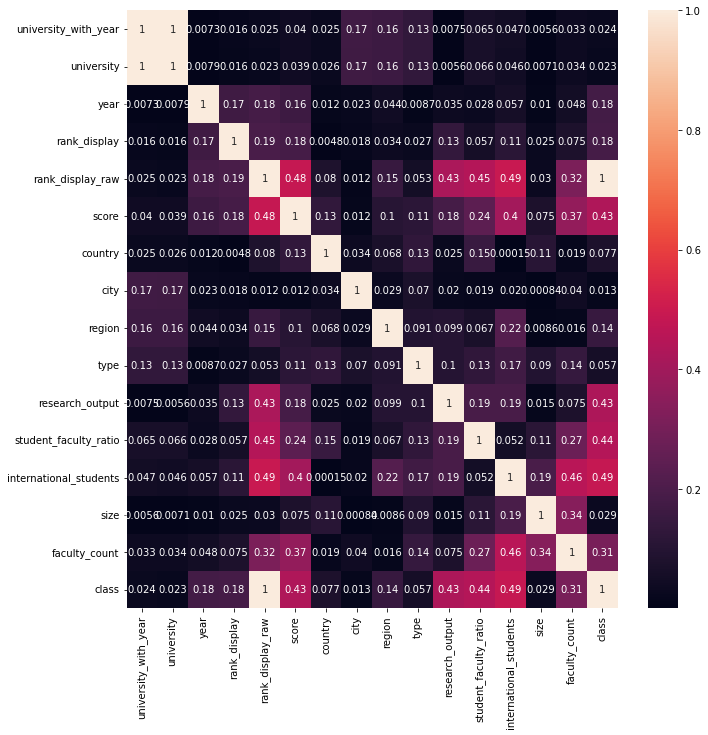

In [65]:
data_corr = data.corr()
plt.figure(figsize = (11,11))
sns.heatmap(abs(data_corr), annot = True)

### Decision Tree

In [66]:
data.dropna(subset = ["class"], inplace = True)

Text(0.5, 0, 'Classes')

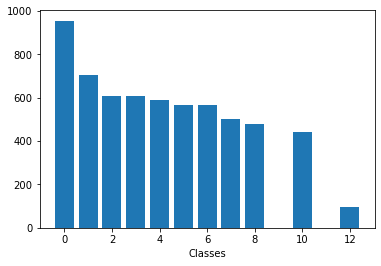

In [67]:
plt.bar(data["class"].unique(), data["class"].value_counts())
plt.xlabel("Classes")

In [68]:
def decision_tree():
    not_feature_cols = ["rank_display", "rank_display_raw", "score"]
    tree_features = data.drop(labels = not_feature_cols, axis = 1)
    (tree_train_x, tree_test_x, tree_train_y, tree_test_y) = train_test_split(tree_features.drop(labels = "class", axis = 1), tree_features["class"], test_size=500)
    
    #Training
    classifier = tree.DecisionTreeClassifier()
    classifier = classifier.fit(tree_train_x, tree_train_y)
    
    predictions = classifier.predict(tree_test_x)
    print("Accuracy:", metrics.accuracy_score(tree_test_y, predictions))
    
decision_tree()

Accuracy: 0.646


### Regression